In [24]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-300')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [0]:
! pip install -q kaggle

In [27]:
import os
os.environ['KAGGLE_USERNAME'] = "flowmxd" # username from the json file
os.environ['KAGGLE_KEY'] = "5015ac13fd7ed1341c7131a253d9c96e" # key from the json file
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection # api copied from kaggle


news-headlines-dataset-for-sarcasm-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
!ls

glove.6B.100d.txt  news-headlines-dataset-for-sarcasm-detection.zip
glove.6B.200d.txt  sample_data
glove.6B.300d.txt  Sarcasm_Headlines_Dataset.json
glove.6B.50d.txt   Sarcasm_Headlines_Dataset_v2.json
glove.6B.zip


In [0]:
import zipfile
zipref = zipfile.ZipFile('news-headlines-dataset-for-sarcasm-detection.zip', 'r')
zipref.extractall()
zipref.close()

In [30]:
!ls

glove.6B.100d.txt  news-headlines-dataset-for-sarcasm-detection.zip
glove.6B.200d.txt  sample_data
glove.6B.300d.txt  Sarcasm_Headlines_Dataset.json
glove.6B.50d.txt   Sarcasm_Headlines_Dataset_v2.json
glove.6B.zip


In [31]:
data_1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [0]:
#DATA CLEANING 

def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [33]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

(-0.5, 999.5, 499.5, -0.5)

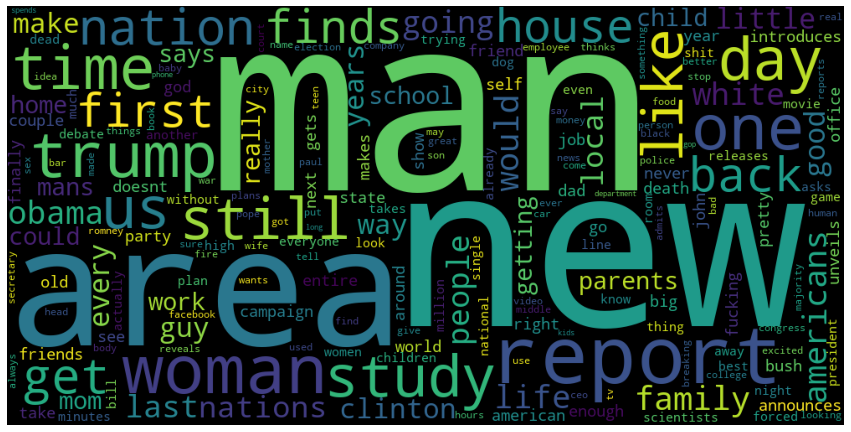

In [34]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [35]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [36]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


In [41]:
!ls

glove.6B.100d.txt  glove.6B.zip.1
glove.6B.200d.txt  news-headlines-dataset-for-sarcasm-detection.zip
glove.6B.300d.txt  sample_data
glove.6B.50d.txt   Sarcasm_Headlines_Dataset.json
glove.6B.zip	   Sarcasm_Headlines_Dataset_v2.json


In [0]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip


In [44]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: t
error:  invalid response [t]
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: t
error:  invalid response [t]
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.200d.txt       
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.300d.txt       


In [45]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.zip.1
glove.6B.200d.txt  news-headlines-dataset-for-sarcasm-detection.zip
glove.6B.300d.txt  sample_data
glove.6B.50d.txt   Sarcasm_Headlines_Dataset.json
glove.6B.zip	   Sarcasm_Headlines_Dataset_v2.json
/content


In [47]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [48]:
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24993


In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [50]:
#build RNN
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           2865800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,908,105
Trainable params: 42,305
Non-trainable params: 2,865,800
_________________________________________________________________
None


In [51]:
#Training

history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Train on 44263 samples, validate on 11065 samples
Epoch 1/25
 - 31s - loss: 0.5795 - acc: 0.7012 - val_loss: 0.4859 - val_acc: 0.7721
Epoch 2/25
 - 31s - loss: 0.5150 - acc: 0.7518 - val_loss: 0.4565 - val_acc: 0.7899
Epoch 3/25
 - 29s - loss: 0.4809 - acc: 0.7746 - val_loss: 0.4242 - val_acc: 0.8078
Epoch 4/25
 - 32s - loss: 0.4604 - acc: 0.7842 - val_loss: 0.3995 - val_acc: 0.8223
Epoch 5/25
 - 32s - loss: 0.4412 - acc: 0.7976 - val_loss: 0.3903 - val_acc: 0.8292
Epoch 6/25
 - 31s - loss: 0.4243 - acc: 0.8068 - val_loss: 0.3734 - val_acc: 0.8359
Epoch 7/25
 - 31s - loss: 0.4104 - acc: 0.8131 - val_loss: 0.3679 - val_acc: 0.8374
Epoch 8/25
 - 30s - loss: 0.4002 - acc: 0.8194 - val_loss: 0.3525 - val_acc: 0.8475
Epoch 9/25
 - 32s - loss: 0.3886 - acc: 0.8246 - val_loss: 0.3513 - val_acc: 0.8504
Epoch 10/25
 - 34s - loss: 0.3809 - acc: 0.8282 - val_loss: 0.3410 - val_acc: 0.8523
Epoch 11/25
 - 31s - loss: 0.3749 - acc: 0.8315 - val_loss: 0.3302 - val_acc: 0.8603
Epoch 12/25
 - 32s - los

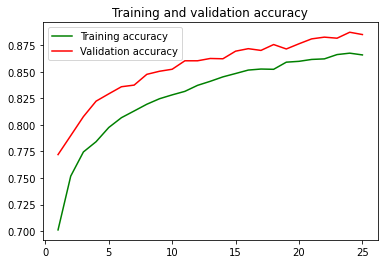

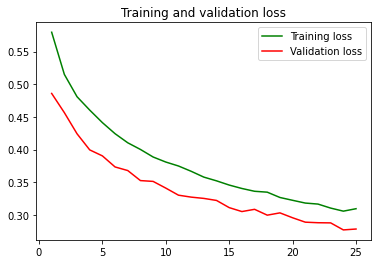

In [52]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [83]:
predict_sarcasm("It’s okay if you don’t like me. Not everyone has good taste.")


"It's not a sarcasm."

In [0]:
filename = 'sarcasm.pkl'
pickle.dump(model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

In [99]:
!ls

CleanTokenize.pickle  news-headlines-dataset-for-sarcasm-detection.zip
glove.6B.100d.txt     sample_data
glove.6B.200d.txt     Sarcasm_Headlines_Dataset.json
glove.6B.300d.txt     Sarcasm_Headlines_Dataset_v2.json
glove.6B.50d.txt      sarcasm.pickle
glove.6B.zip	      sarcasm.pkl
glove.6B.zip.1	      tokenizer.pickle


In [100]:
os.listdir('.')
!pwd

/content


In [0]:
from google.colab import files
files.download('sarcasm.pkl')

In [0]:
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [107]:
!ls

CleanTokenize.pickle
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
glove.6B.50d.txt
glove.6B.zip
glove.6B.zip.1
news-headlines-dataset-for-sarcasm-detection.zip
sample_data
Sarcasm_Headlines_Dataset.json
Sarcasm_Headlines_Dataset_v2.json
sarcasm.pickle
sarcasm.pkl
tokenizer.pickle
tokenizer.pkl


In [0]:
from google.colab import files
files.download('tokenizer.pkl')

In [0]:
filename = 'sarcasm.pkl'
filename2 = 'tokenizer.pkl'
clf = pickle.load(open(filename, 'rb')) 

def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = clf.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [112]:
predict_sarcasm("You just broke my car window. Great job.")


"It's a sarcasm!"